# Apollo Hospital usecase


Apollo Hospitals was established in 1983. It is acclaimed for pioneering the private healthcare revolution in the country.

One of the best examples of data scientists making a meaningful difference at a global level is in the response to the COVID-19 pandemic, where they have improved information collection, provided ongoing and accurate estimates of infection spread and health system demand, and assessed the effectiveness of government policies.

## Columns

Age: This is an integer indicating the age of the primary beneficiary (excluding those above 64 years, since they are generally covered by the government). <br>
Sex: This is the policy holder's gender, either male or female<br>
Viral Load: Viral load refers to the amount of virus in an infected person's blood<br>
Severity Level: This is an integer indicating how severe the patient is<br>
Smoker: This is yes or no depending on whether the insured regularly smokes tobacco.<br>
Region: This is the beneficiary's place of residence in Delhi, divided into four geographic regions - northeast, southeast, southwest, or northwest<br>
Hospitalization charges: Individual medical costs billed to health insurance<br>

# Problem statement

The company wants to know:

• To understand which variables are significant in predicting the reason for hospitalization for different regions.

• How well some variables like viral load, smoking, Severity Level describe the hospitalization charges.

These insights might help the hospital to plan and equip better for emergencies and also make daily operations smoother. 

# Imports

In [499]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind           ## 2 sample independent T-test
from scipy.stats import chi2_contingency   ## chi-squared test for testing the independence between 2 catergoical variables
from scipy.stats import shapiro            ## shapiro-wilk test for normality
from scipy.stats import f_oneway           ## one-way Anova test for comparing 3 or more categorial variables
from scipy.stats import levene             ## for checking equal variance of samples

In [208]:
sns.set_style('whitegrid')
sns.set_context('talk')

# Loading data and EDA

In [211]:
df = pd.read_csv('scaler_apollo_hospitals.csv', index_col=0)

In [212]:
df.head()

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
1,18,male,no,southeast,11.26,1,4314
2,28,male,no,southeast,11.00,3,11124
3,33,male,no,northwest,7.57,0,54961
4,32,male,no,northwest,9.63,0,9667


In [213]:
df.shape

(1338, 7)

In [219]:
df.isna().sum()

age                        0
sex                        0
smoker                     0
region                     0
viral load                 0
severity level             0
hospitalization charges    0
dtype: int64

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1338 non-null   int64  
 1   sex                      1338 non-null   object 
 2   smoker                   1338 non-null   object 
 3   region                   1338 non-null   object 
 4   viral load               1338 non-null   float64
 5   severity level           1338 non-null   int64  
 6   hospitalization charges  1338 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 83.6+ KB


## Attributes properties

In [224]:
df['sex'].value_counts(normalize=True)

male      0.505232
female    0.494768
Name: sex, dtype: float64

In [227]:
df['smoker'].value_counts(normalize=True)

no     0.795217
yes    0.204783
Name: smoker, dtype: float64

In [228]:
df['region'].value_counts(normalize=True)

southeast    0.272048
northwest    0.242900
southwest    0.242900
northeast    0.242152
Name: region, dtype: float64

In [300]:
df['severity level'].value_counts(normalize=True)*100

0    42.899851
1    24.215247
2    17.937220
3    11.733931
4     1.868460
5     1.345291
Name: severity level, dtype: float64

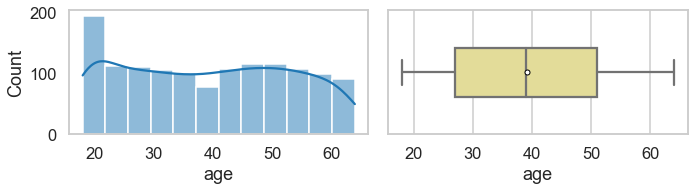

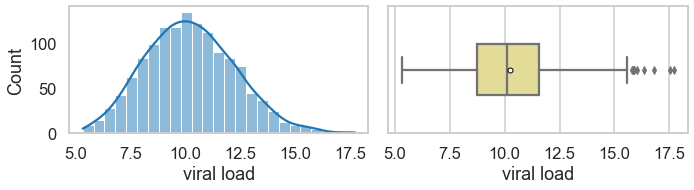

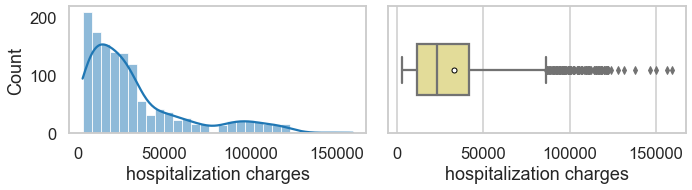

In [284]:
for feature in ['age', 'viral load', 'hospitalization charges']:
    plt.subplots(1,2,figsize=(10,3))
    #     plt.suptitle(f'{final_group} from 2020-Jan till 2021-May - Brida 4 master',y=1.01,color='Orange')
    plt.subplot(1,2,1)
    ax1 = sns.histplot(df[feature], kde=True)
    ax1.set_ylabel('Count')

    plt.subplot(1,2,2)
    ax2 = sns.boxplot(data=data, x=feature, width=0.4,color='khaki',fliersize=5, showmeans=True, meanprops={"marker":"o",
                                                                "markerfacecolor":"white", 
                                                                "markeredgecolor":"black",
                                                                "markersize":"5"})
    ax1.grid(alpha=0.3)
#     ax2.grid(alpha=0.3, axis='both')
    plt.tight_layout(pad=1.1)

In [246]:
df[['age', 'viral load', 'hospitalization charges']].describe().round(2)

,age,viral load,hospitalization charges
count,1338.00,1338.00,1338.00
mean,39.21,10.22,33176.06
std,14.05,2.03,30275.03
min,18.00,5.32,2805.00
25%,27.00,8.76,11851.00
50%,39.00,10.13,23455.00
75%,51.00,11.57,41599.50
max,64.00,17.71,159426.00


In [285]:
df.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [293]:
corr = df.corr()

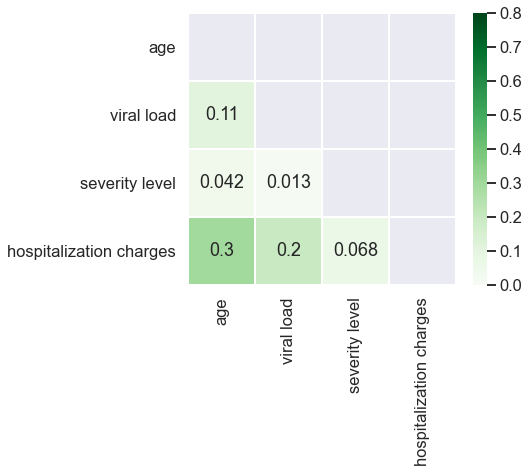

In [298]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(6, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=0.8, vmin=0,annot=True, linewidths=1, cmap='Greens')

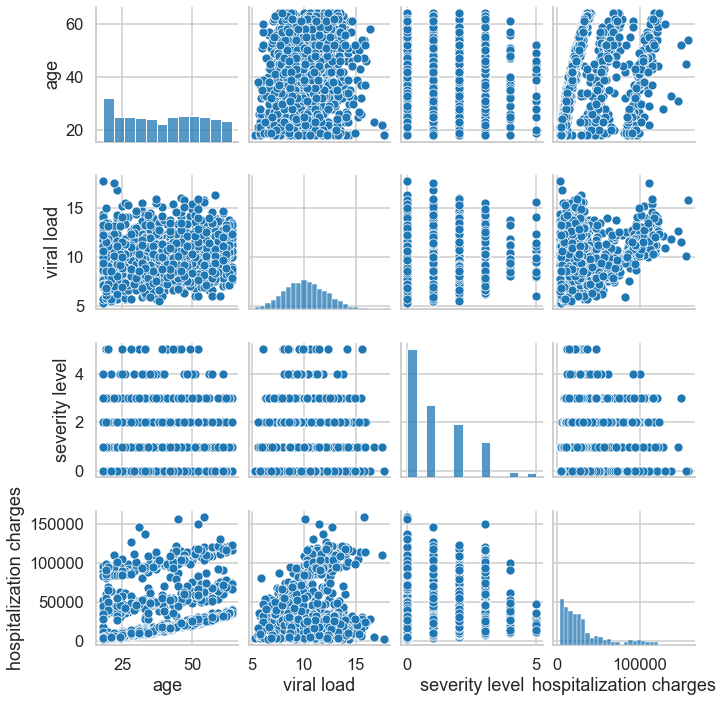

In [295]:
sns.pairplot(df)

## Observations 1:

1. All the datatypes are okay. Strings are objects and numerical values are int/float.
2. No missing values found.
3. Data of two genders (male and female with approx. equal proportion) distributed across 4 different regions of India are given.
4. There are about 20% smokers and 80% non-smokers in the study.
5. The severity level ranges from 0 to 5. 5 being the highest severity.
6. Severity of 4 and 5 are less than 2% in the data individually and level 0 being 42% of the data.
7. The patients age range from 18 to 64 with a median of 39 years. 
8. Viral load goes from ~5 to ~18 units.
9. There are outliers in viral load and hospitalization charges.
10. None of the numerical features seem to be highly co-related amongst each other.

##### 

# Hypothesis tests: <br> $\color{red}{\text{The significance level considered is always 5%!}}$

### Test 1: Prove (or disprove) that the hospitalization charges of people who do smoking is greater than those who don't? (T-test Right tailed)

In [301]:
df.head()

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
1,18,male,no,southeast,11.26,1,4314
2,28,male,no,southeast,11.00,3,11124
3,33,male,no,northwest,7.57,0,54961
4,32,male,no,northwest,9.63,0,9667


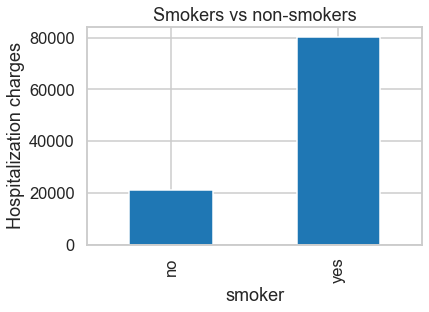

In [385]:
df.groupby('smoker')['hospitalization charges'].mean().plot(kind='bar')
plt.ylabel('Hospitalization charges')
plt.title('Smokers vs non-smokers')
plt.show()

The is difference in the mean of hopital bills for smokers and non-smokers. If the difference is statistically significant can be checked with a right-tailed test.

**Assumptions of T-test**

1. Observations in each sample are independent.
2. Observations in each sample are normally distributed.
3. Observations in each sample have the same variance.


a. We assume that the sample was randomly and independently collected. <br>
b. Since we use sampling distribution of the sample means as test statistic, by the virtue of central limit theorem, the sample is normally distributed. <br>
c. We have to check for equal variances. (levene test: https://www.itl.nist.gov/div898/handbook/eda/section3/eda35a.htm)

In [509]:
df.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [510]:
smoker = df[df['smoker']=='yes']['hospitalization charges'].sample(274)
non_smoker = df[df['smoker']=='no']['hospitalization charges'].sample(274)

In [511]:
levene(smoker, non_smoker)

LeveneResult(statistic=147.25066181434073, pvalue=3.607549113536195e-30)

Since the p-value is smaller than 0.05, we reject the null hypothesis and conclude that the observations don't have equal variance. 

As stated in the question, we would still go ahead and do a t-test.

In [513]:
test_type = 'greater'
test = '2 sample independent t-test'
print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of smokers and non-smokers in terms of hospital bills.')
print(' ')
print('Ha1: The charges are higher for smokers than non-smokers.')
print(' ')
test_result = ttest_ind(smoker, non_smoker, alternative = test_type)
print(f'Results of the test:')
print(' ')
print(f'Test-type: {test_type}')
print(test_result)
print(' ')
print('Since the p-value is less than 0.05, we reject the null hypothesis.')
print(' ')
print('Inference: The hospital bills for smokers is higher than non-smokers.')

 
############## 2 sample independent t-test ################
 
H0: There is no difference in the population mean of smokers and non-smokers in terms of hospital bills.
 
Ha1: The charges are higher for smokers than non-smokers.
 
Results of the test:
 
Test-type: greater
Ttest_indResult(statistic=29.510974659308857, pvalue=1.8857912222374225e-115)
 
Since the p-value is less than 0.05, we reject the null hypothesis.
 
Inference: The hospital bills for smokers is higher than non-smokers.


##### 

### Test 2: Prove (or disprove) with statistical evidence that the viral load of females is different from that of males (T-test Two tailed)

In [373]:
df.groupby('sex')['viral load'].mean()

sex
female    10.126073
male      10.314423
Name: viral load, dtype: float64

##### The mean of the viral load for males and females are not very different from each other. Let's do a two-tailed T-test to see if the small difference is statistically justified. 

Since the t-test uses the concept of sampling distribution of sample means and CLT, the normality assumption need not be checked.

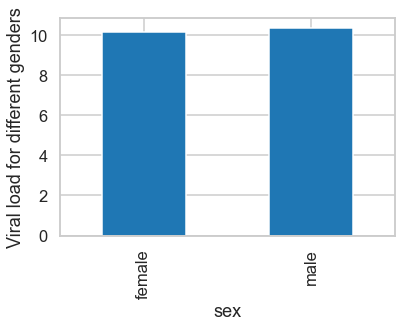

In [388]:
df.groupby('sex')['viral load'].mean().plot(kind='bar')
plt.ylabel('Viral load for different genders')
plt.show()

The is difference in the mean of hopital bills for smokers and non-smokers. If the difference is statistically significant can be checked with a right-tailed test.

**Assumptions of T-test**

1. Observations in each sample are independent.
2. Observations in each sample are normally distributed.
3. Observations in each sample have the same variance.


a. We assume that the sample was randomly and independently collected. <br>
b. Since we use sampling distribution of the sample means as test statistic, by the virtue of central limit theorem, the sample is normally distributed. <br>
c. We have to check for equal variances. (levene test: https://www.itl.nist.gov/div898/handbook/eda/section3/eda35a.htm)

In [514]:
males = df[df['sex'] == 'male']['viral load'].sample(600)
females = df[df['sex'] == 'female']['viral load'].sample(600)

In [515]:
levene(males, females)

LeveneResult(statistic=0.06404096121472733, pvalue=0.8002628258390498)

Since the p-value is higher than 0.05, we cannot reject the null hypothesis. Thus, the assumption of equal variance is valid.

In [516]:
# Test: 

test_type = 'two-sided'
test = '2 sample independent t-test'
print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of viral load between males and females.')
print(' ')
print('Ha1: There is a difference.')
print(' ')
test_result = ttest_ind(males, females, alternative = test_type)
print(f'Results of the test:')
print(' ')
print(f'Test-type: {test_type}')
print(test_result)
print(' ')
print('Since the p-value is more than 0.05, we fail to reject the null hypothesis.')
print(' ')
print('Inference: There is no difference in the population mean of the viral load between males and females population.')

 
############## 2 sample independent t-test ################
 
H0: There is no difference in the population mean of viral load between males and females.
 
Ha1: There is a difference.
 
Results of the test:
 
Test-type: two-sided
Ttest_indResult(statistic=1.6986230664055966, pvalue=0.08964988052519911)
 
Since the p-value is more than 0.05, we fail to reject the null hypothesis.
 
Inference: There is no difference in the population mean of the viral load between males and females population.


##### 

### Test 3: Is the proportion of smoking significantly different across different regions? (Chi-square test of independece)

In [329]:
df.head(3)

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
1,18,male,no,southeast,11.26,1,4314
2,28,male,no,southeast,11.00,3,11124


In [332]:
contigency_table = pd.crosstab(df['smoker'], df['region'])

contigency_table

region,northeast,northwest,southeast,southwest
smoker,,,,
no,257,267,273,267
yes,67,58,91,58


**Assumptions of Chi-square test:**

1. Variables are categorical.
2. All observations are independent.
3. The frequencies in the contigency table should be atleast 5 (else correction factor is employed.)

We know the variables are categorical and the samples would have been collected independently. The frequencies in the above contigency table are all above 5, so we are good with the assumptions of chi2 test.

In [337]:
# Test: 

test = 'Chi-square test of independence since we are comparing two categorical variables.'
print(' ')
print('Does region affect the number of smokers?')

print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: Regions does not affect the proportion of smokers.')
print(' ')
print('Ha: Not independent')
print(' ')
chi2_statistic, p_value_chi2, dof, expected_frequencies = chi2_contingency(contigency_table)
print(f'Results of the test:')
print(' ')
print(f'Test-type: Chi-square test of independence')
print(' ')
print(f'chi2_statistic: {chi2_statistic}')
print(' ')
print(f'p_value_chi2: {p_value_chi2}')
print(' ')
print(f'Degree of freedom: {dof}')
print(' ')
print(f'expected_frequencies: {expected_frequencies}')
print(' ')
print('Since the p-value is greater than 0.05, we fail to reject the null hypothesis.')
print(' ')
print('Inference: The proportion of smokers is independent of the region.')

 
Does region affect the number of smokers?
 
############## Chi-square test of independence since we are comparing two categorical variables. ################
 
H0: Regions does not affect the proportion of smokers.
 
Ha: Not independent
 
Results of the test:
 
Test-type: Chi-square test of independence
 
chi2_statistic: 7.34347776140707
 
p_value_chi2: 0.06171954839170547
 
Degree of freedom: 3
 
expected_frequencies: [[257.65022422 258.44544096 289.45889387 258.44544096]
 [ 66.34977578  66.55455904  74.54110613  66.55455904]]
 
Since the p-value is greater than 0.05, we fail to reject the null hypothesis.
 
Inference: The proportion of smokers is independent of the region.


<AxesSubplot:xlabel='smoker'>

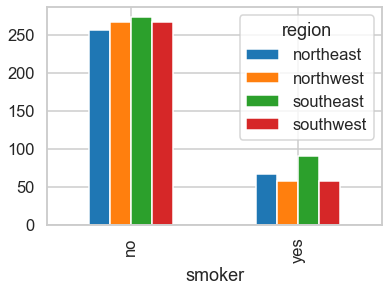

In [338]:
contigency_table.plot(kind='bar')

##### There are minor differences in the number of smokers in each region but the test above shows that the difference is not statistically significant.

##### 

### Test 4: Is the mean viral load of women with 0 Severity level , 1 Severity level, and 2 Severity level the same? Explain your answer with statistical evidence 
**(One way Anova test)**

In [483]:
df.head()

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
1,18,male,no,southeast,11.26,1,4314
2,28,male,no,southeast,11.00,3,11124
3,33,male,no,northwest,7.57,0,54961
4,32,male,no,northwest,9.63,0,9667


In [484]:
females = df[df['sex'] == 'female']

In [485]:
females.groupby('severity level')['viral load'].mean()

severity level
0    10.120727
1    10.017468
2    10.216807
3    10.145974
4    10.647273
5    10.206250
Name: viral load, dtype: float64

Text(0, 0.5, 'Viral load')

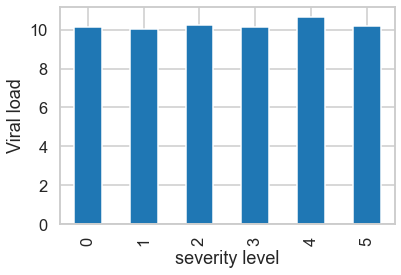

In [492]:
females.groupby('severity level')['viral load'].mean().plot(kind='bar')
plt.ylabel('Viral load')

In [493]:
females.groupby('severity level')['viral load'].count()

severity level
0    289
1    158
2    119
3     77
4     11
5      8
Name: viral load, dtype: int64

##### 

The mean viral load difference between severity 0, 1, 2 is minor. One way Anova test would be useful to see if the minor difference is statistically significant.


<br>

**Assumptions of Analysis of Variance (Anova):**

1. Observations in each sample are normally distributed. To check for normality we can use shapiro-wilk test<br>
2. Observations in each sample have the same variance. Check with Levene test.

In [494]:
sev_0 = df[df['severity level'] == 0]['viral load'].sample(110)
sev_1 = df[df['severity level'] == 1]['viral load'].sample(110)
sev_2 = df[df['severity level'] == 2]['viral load'].sample(110)

### Normality test (shapiro wilk)

H0: the sample has a Gaussian distribution. <br>
H1: the sample does not have a Gaussian distribution.

In [495]:
stat, p = shapiro(sev_0)
print(stat, p)

stat, p = shapiro(sev_1)
print(stat, p)

stat, p = shapiro(sev_2)
print(stat, p)

0.9789667725563049 0.0794575959444046
0.9876510500907898 0.4124608337879181
0.9852475523948669 0.26835790276527405


Since the p-value is more than 0.05, we fail to reject the null hypothesis and conclude that the samples drawn are normal.

In [362]:
print(sev_1.mean())
print(sev_2.mean())
print(sev_3.mean())

10.149610389610393
10.143766233766236
10.071298701298696


### Equal variance test (levene test)

In [496]:
sev_0.var()

3.336977614678899

In [497]:
sev_1.var()

4.012349991659718

In [498]:
sev_2.var()

4.964949924937447

The variances of the 3 samples are similar. It is better to use the levene test to draw a statistical inference. <br>

### Levene test:

H0: The samples have equal variances. <br>
Ha: The variances are not equal.

In [504]:
print(levene(sev_0, sev_1, sev_2))

print('Since p-value is more than 0.05, we fail to reject the null hypothesis. We can use the ANOVA test')

LeveneResult(statistic=1.6577521370914767, pvalue=0.1921643254688861)
Since p-value is more than 0.05, we fail to reject the null hypothesis. We can use the ANOVA test


In [505]:
# Test: 

test = 'One way ANOVA since we are comparing means between 3 types of categories (more than 2 categories)'
print(' ')
print('There is a minor difference in the mean of viral load between severity 1,2, and 3.' 
      ' Let us find if it is statistically significant?')

print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of the viral load for severity 1, 2, and 3.')
print(' ')
print('Ha: The viral load is different for different severity.')
print(' ')
test_result = f_oneway(sev_0, sev_1, sev_2)
print(f'Results of the test:')
print(' ')
print(f'Test-type: 1-way ANOVA')
print(test_result)
print(' ')
print('Since the p-value is more than 0.05, we fail to reject the null hypothesis.')
print(' ')
print('Inference: There is no difference in the viral load of the patients with severity 1, 2, or 3.')

 
There is a minor difference in the mean of viral load between severity 1,2, and 3. Let us find if it is statistically significant?
 
############## One way ANOVA since we are comparing means between 3 types of categories (more than 2 categories) ################
 
H0: There is no difference in the population mean of the viral load for severity 1, 2, and 3.
 
Ha: The viral load is different for different severity.
 
Results of the test:
 
Test-type: 1-way ANOVA
F_onewayResult(statistic=2.655394255581096, pvalue=0.07178628314056032)
 
Since the p-value is more than 0.05, we fail to reject the null hypothesis.
 
Inference: There is no difference in the viral load of the patients with severity 1, 2, or 3.


##### 

# Miscellaneous analysis

In [389]:
df.head()

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
1,18,male,no,southeast,11.26,1,4314
2,28,male,no,southeast,11.00,3,11124
3,33,male,no,northwest,7.57,0,54961
4,32,male,no,northwest,9.63,0,9667


### Hospitalization charges for different regions

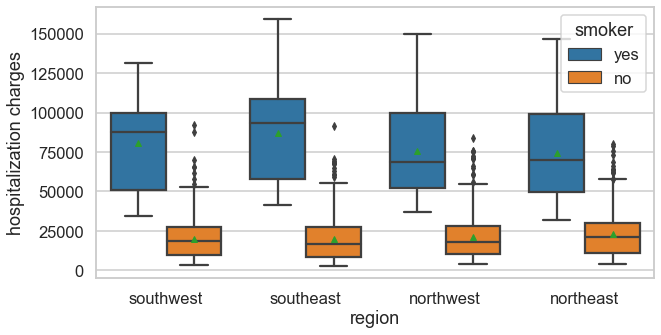

In [469]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, y='hospitalization charges', x='region', hue='smoker', showmeans=True)
plt.show()

### Observations:

1. The hospital bills are higher for smokers than non-smokers across all the regions.
2. The median bill for non-smokers are similar for all 4 regions but higher for smokers in the southern part of the country.

### Hospitalization charges males vs females

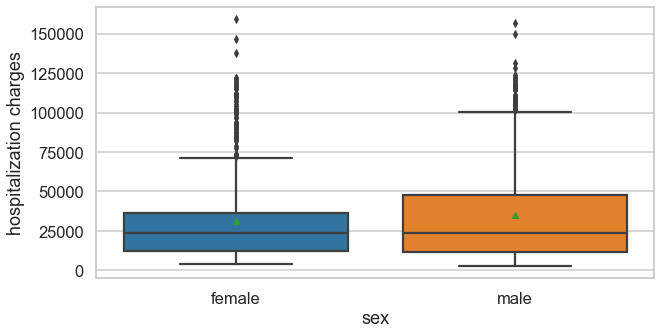

In [399]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, y='hospitalization charges', x='sex', showmeans=True)
plt.show()

Let's check if the charges are similar for males and females or similar using a 2 sample independent t-test.

In [401]:
males = df[df['sex'] == 'male']['hospitalization charges']
females = df[df['sex'] == 'female']['hospitalization charges']

print(males.mean())
print(females.mean())

34891.88461538462
31423.945619335347


In [407]:
# Test: 

test_type = 'greater'
test = '2 sample independent t-test'
print(' ')
print(f'############## {test} ################')
print(' ')
print('H0: There is no difference in the population mean of hospital bill between males and females.')
print(' ')
print('Ha1: It is higher for males')
print(' ')
test_result = ttest_ind(males, females, alternative = test_type)
print(f'Results of the test:')
print(' ')
print(f'Test-type: {test_type}')
print(test_result)
print(' ')
print('Since the p-value is more than 0.05, we reject the null hypothesis.')
print(' ')
print('Inference: The hospital bills are higher for males than females population.')

 
############## 2 sample independent t-test ################
 
H0: There is no difference in the population mean of hospital bill between males and females.
 
Ha1: It is higher for males
 
Results of the test:
 
Test-type: greater
Ttest_indResult(statistic=2.0975514588775326, pvalue=0.01806614486585949)
 
Since the p-value is more than 0.05, we reject the null hypothesis.
 
Inference: The hospital bills are higher for males than females population.


### Hospital bill vs gender smoking or not.

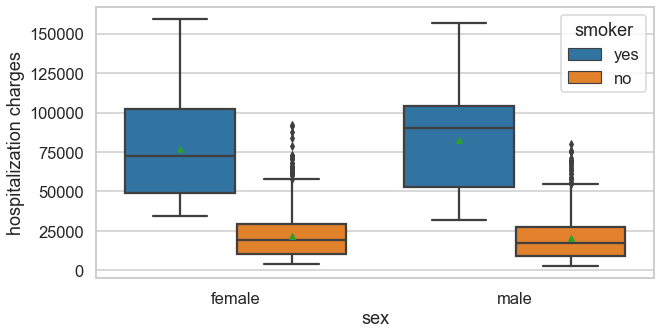

In [408]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, y='hospitalization charges', x='sex', hue='smoker', showmeans=True)
plt.show()

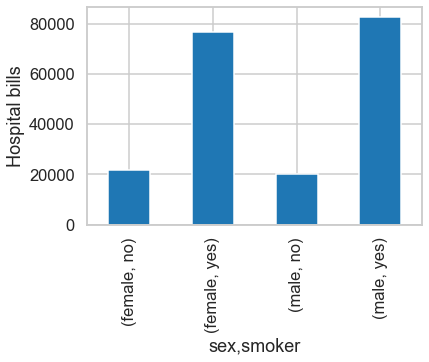

In [413]:
df.groupby(['sex', 'smoker'])['hospitalization charges'].mean().plot(kind='bar')
plt.ylabel('Hospital bills')
plt.show()

### Observation:

1. The average hospital bill for males is higher than for females in general, however, that difference mainly comes from smoking population. In other words, smoking males pay higher hospital bills than smoking females. 

##### 

In [414]:
df.head()

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
1,18,male,no,southeast,11.26,1,4314
2,28,male,no,southeast,11.00,3,11124
3,33,male,no,northwest,7.57,0,54961
4,32,male,no,northwest,9.63,0,9667


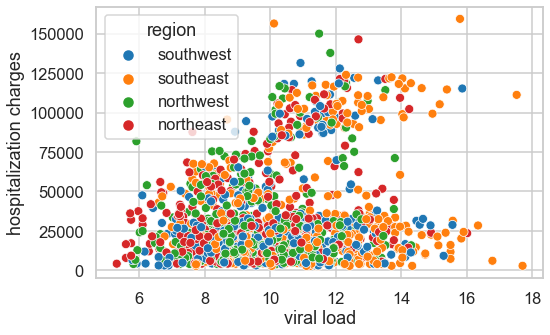

In [431]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x=df['viral load'], y=df['hospitalization charges'], hue='region')
plt.show()

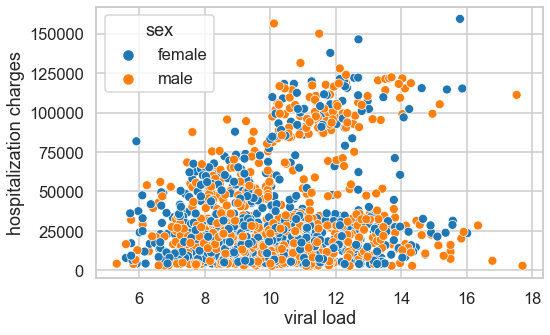

In [432]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x=df['viral load'], y=df['hospitalization charges'], hue='sex')
plt.show()

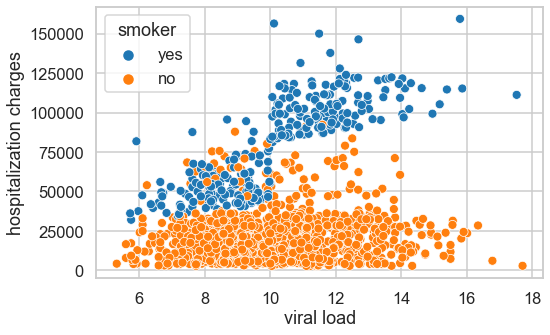

In [477]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x=df['viral load'], y=df['hospitalization charges'], hue='smoker')
plt.show()

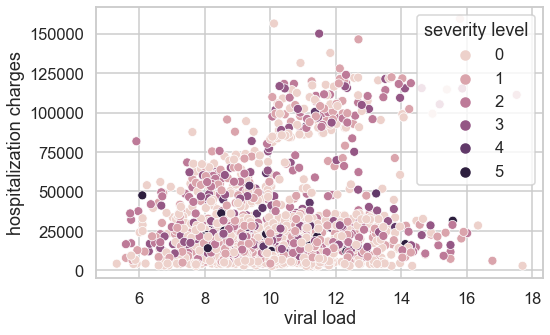

In [479]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x=df['viral load'], y=df['hospitalization charges'], hue='severity level')
plt.show()

### Observation:
1. Apparently, viral load for hospitalization charges shows a pattern only for smokers. It increases with viral load. 
2. For non-smokers, it is more or less the same. Apart from these, no other factors show a clear trend with viral load for predicting hospital bills.

##### 

### Bills vs severity

<AxesSubplot:xlabel='severity level', ylabel='hospitalization charges'>

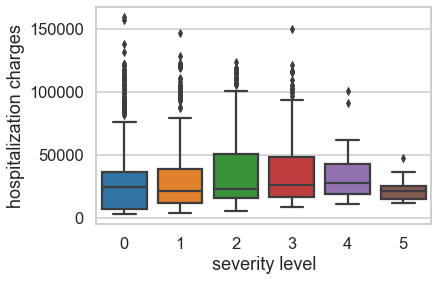

In [475]:
sns.boxplot(data=df, x='severity level', y='hospitalization charges')

<AxesSubplot:xlabel='sex,severity level'>

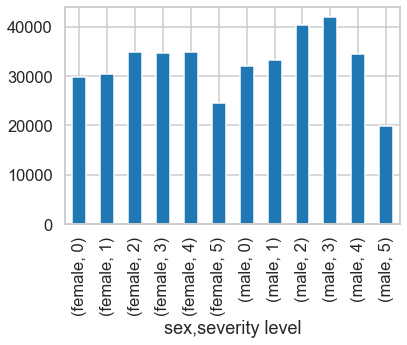

In [452]:
df.groupby([ 'sex','severity level'])['hospitalization charges'].mean().plot(kind='bar')

<AxesSubplot:xlabel='severity level', ylabel='hospitalization charges'>

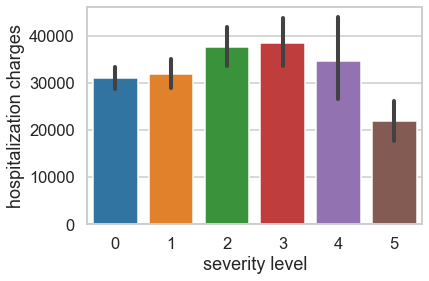

In [457]:
sns.barplot(data=df, x='severity level', y='hospitalization charges')

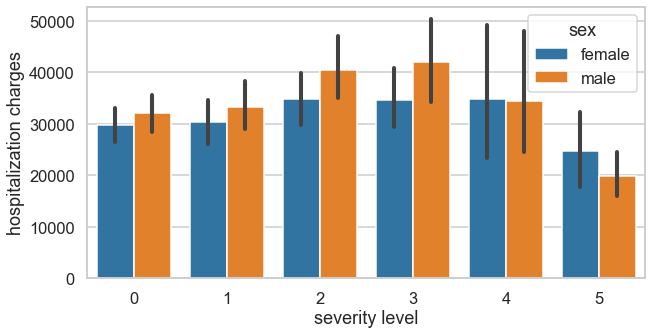

In [473]:
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='severity level', y='hospitalization charges', hue='sex')
plt.show()

### Observations:

1. In general, the charges are higher for severity level 2 or 3 than 5. And, higher for males with severity level 0,1,2,3 and lowest for 5.

### Bills vs Age

<AxesSubplot:xlabel='age', ylabel='hospitalization charges'>

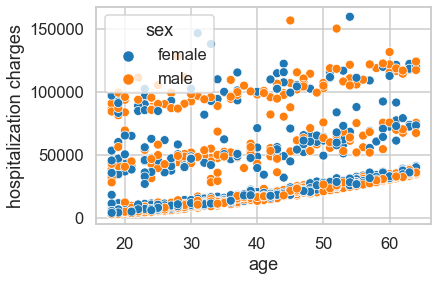

In [471]:
sns.scatterplot(data=df, x='age', y='hospitalization charges', hue='sex')

Observation:
    
1. In general, charges increase with age but this is not always true.

<AxesSubplot:xlabel='smoker', ylabel='count'>

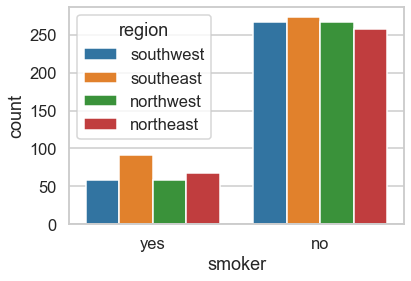

In [482]:
sns.countplot(data=df, x='smoker', hue='region')

# Recommendations:

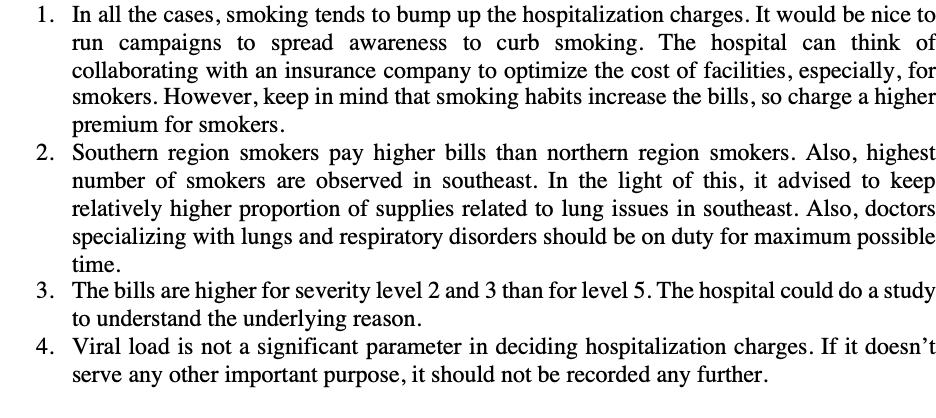